# MiniProject 2: Multi-Class Logistic Regression and Gradient Descent


> MiniProject 2 of COMP 551 (Fall 2020) at McGill University


> Authors (G73): Haoran Du, Gabriel Crene, Panayiotis Demopoulos





In [ ]:
import numpy as np
import scipy as sci
import pandas as pd
import time

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

# Task 2: Softmax Regression

In [ ]:
class GradientDescent:

    def __init__(self, learning_rate=.01, beta=0.99, epsilon=1e-8, batch_size=1):
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.lmbda=0.0
        self.cost_history = []

    def compute_epoch_cost(self, X, W, b, y):
        z = SoftmaxRegression.compute_z(X, W, b)
        y_hat = SoftmaxRegression.softmax(z)
        cross_entropy = SoftmaxRegression.cross_entropy_fn(y_hat, y)
        return SoftmaxRegression.cost_fn(cross_entropy, W)

    def create_mini_batches(self, y, batch_count):
        y_n = np.arange(y.shape[0])
        # permuting our y_n vector:
        y_n = np.random.permutation(y_n)
        if batch_count > 1:
            rmdr = y.shape[0] % batch_count
            if rmdr:
                batches = np.array_split(y_n[:-rmdr], batch_count)
                batches[-1] = np.concatenate((batches[-1], y_n[-rmdr:]), axis=0)
            else:
                batches = np.array_split(y_n, batch_count)
        else:
            batches = (y_n,)
        for i in batches:
            yield i
            
    def run(self, gradient_fn, X, y_one_hot, W, b, lmbda=0.0):
        self.lmbda = lmbda # For ridge regression purposes
        self.batch_count = X.shape[0]//self.batch_size
        
        z = 0
        
        batches = self.create_mini_batches(y_one_hot, batch_count=self.batch_count)
        for i in batches:
            
            # Indexing X and Y values:
            X_mini = X[i]
            y_mini = y_one_hot[i]
            
            try:
                # Computing Gradient:
                grad, bias_grad = gradient_fn(X_mini, y_mini, W, b)  # compute the gradient with present weight
                z = self.beta * z + (1 - self.beta) * grad
            except Exception as e:
                    print(f'X_mini:{X_mini}, y_mini:{y_mini}')
                    print(e.with_traceback)
                    raise
            
            # Updating weights
            W -= self.learning_rate * z
            b -= self.learning_rate * bias_grad
            
            break # we take only one random batch as they are size batch_size
                  
        cost = self.compute_epoch_cost(X, W, b, y_one_hot)
        self.cost_history.append(cost)
        return W, b, self.cost_history

        sdsdfdsf

This was taken from the gradient descent collab, will be replaced with our softmax function:

In [ ]:
from sklearn.preprocessing import OneHotEncoder


class SoftmaxRegression:
    def __init__(self,
                 lmbda=0.0,
                max_iters=1000):
        self.max_iters = max_iters
        self.lmbda = lmbda
        self.y_one_hot = OneHotEncoder()
        self.W = None
        self.b = None
        self.tr_acc_history = []
        self.test_acc_history = []
        self.cost = []
        self.total_iterations = 0

    def compute_z(X, W, b):
        return (X.dot(W) + b)

    def softmax(x):
        """In order to avoid underflow and overflow problem, we shift x bu substracting the maximum element in it fromm all elements. ref: https://stackoverflow.com/questions/42599498/numercially-stable-softmax"""
        z = x - np.max(x, axis=-1, keepdims=True)
        numerator = np.exp(z)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        softmax = numerator / denominator
        return softmax

    def cross_entropy_fn(y_hat, y_c):
        return -np.sum((y_c)*np.log(y_hat), axis=1)

    def cost_fn(cross_entropy, W, lmbda=0.0):
        ridge_reg = lmbda / 2 * np.sum(W ** 2)
        cost_term = cross_entropy + ridge_reg
        return 0.5 * np.mean(cost_term)


    def fit(self, X, y, X_test, y_test, optimizer, termination_bound=20, init_params=True):
        m, n = X.shape
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        self.y_one_hot.fit(y)
        y_one_hot = self.y_one_hot.transform(y).A
        _, nn = y_one_hot.shape

        self.W = np.random.randn(n, nn)/100
        self.b = np.zeros(nn)
        
        T = 0
        param_history = [(0, 0, 0)]
        validation_error_history = [np.inf]
        test_acc_history = [0]

        def gradient(X, y, W, b):
            z = SoftmaxRegression.compute_z(X, W, b)
            y_hat = SoftmaxRegression.softmax(z)
            delta = y_hat - y

            # gradient -> n_features x n_classes
            grad = np.dot(X.T, delta)
            bias_grad = np.sum(delta, axis=0)
            return grad, bias_grad
        
        for i in range(self.max_iters):
            self.total_iterations = i ## For external use only
            self.W, self.b, self.cost = optimizer.run(gradient, X, y_one_hot, self.W, self.b, lmbda=self.lmbda)
            param_history.append((self.W.copy(), self.b.copy(), self.cost.copy()))
            
            self.test_acc_history.append(self.getAccuracy(X_test, y_test)) # For external use
            self.tr_acc_history.append(self.getAccuracy(X, y)) # For external use
            
            y_hat_class = self.predict(X_test)
            validation_error = np.sum(y_hat_class == y_test)
            
            validation_error_history.append(validation_error)
            test_acc_history.append(self.getAccuracy(X_test, y_test))
            
            
            if len(validation_error_history) > 20:
                validation_error_history.pop(0)
                param_history.pop(0)
                test_acc_history.pop(0)

            if validation_error_history[-1] >= validation_error_history[-2]:
                T += 1
            else:
                T = 0
 
            # > because index(0) does not count:
            if T > termination_bound:
                t = test_acc_history.index(max(test_acc_history))
                self.W, self.b, self.cost = param_history[t]
                return self

        return self

    def predict(self, X):
        z = SoftmaxRegression.compute_z(X, self.W, self.b)
        y_hat = SoftmaxRegression.softmax(z)
        return y_hat.argmax(axis=1)
    
    def getAccuracy(self, X,y):
        y_hat_class = self.predict(X)
        accuracy = np.sum(y_hat_class == y)/(float(len(y)))
        return accuracy
    
    def getAccuracyAndCostHistory(self):
        return self.test_acc_history, self.cost

    def getTrainingAccuracy(self):
        return self.tr_acc_history

    def getTotalIterations(self):
        return self.total_iterations


# Task 3: Running Hyper-parameters benchmarks

## 3.1 Grid Search: run-time analysis

### Fitting Functions for the different models:

In [ ]:
def data_split(data, target, test_size, shuffle=True, k_fold=5):
    N, = target.shape

    if shuffle:
        indices = np.random.permutation(N)
        data = data[indices]
        target = target[indices]
    
    # for each of the 5 fold cross validation, we do a grid search over hyper-parameters
    # reserve 5% of all data for testing
    X_train, X_test = np.split(data, [int(test_size * len(data))])
    y_train, y_test = np.split(target, [int(test_size * len(target))])
    validation_size = (int(test_size * len(target))//k_fold)

    return X_train, X_test, y_train, y_test, validation_size


#### __Softmax__ Classifier

In [ ]:
betas = [0.01,0.2,0.5,0.8, 0.9, 0.95, 0.99]
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]


def run_analysis(X_train, y_train, X_test, y_test, validation_size, betas, learning_rates, batch_sizes, termination_bound=20, verbose=False, k_fold=5):
    optimizer = GradientDescent()

    t = 0 # this one is use to display how far we are in the computation:

    perf_df = pd.DataFrame(columns=["beta", "learning_rate", "batch_size", "trainingAccuracy", "testingAccuracy", "performance"])

    for i in range(len(betas)):
        for j in range(len(learning_rates)):
            for k in range(len(batch_sizes)):

                # Reset the k-fold mean dataset
                perf_df_k = None
                perf_df_k = pd.DataFrame(columns=["beta", "learning_rate", "batch_size", "trainingAccuracy", "testingAccuracy", "performance"])
                for m in range(k_fold):
                    validation_indices = np.arange(start=validation_size * m, stop=validation_size * (m + 1), step=1)

                    X_train_k = np.delete(X_train, validation_indices, 0)
                    y_train_k = np.delete(y_train, validation_indices)
                    X_test_k = np.take(X_train, validation_indices, 0)
                    y_test_k = np.take(y_train, validation_indices)

                    optimizer.batch_size = batch_sizes[k]
                    optimizer.learning_rate = learning_rates[j]
                    optimizer.beta = betas[i]
                    classifier = SoftmaxRegression(lmbda=0.00)

                    start = time.time()
                    if(verbose):
                        %time classifier.fit(X_train_k, y_train_k, X_test_k, y_test_k, optimizer, termination_bound=termination_bound)
                    else:
                        classifier.fit(X_train_k, y_train_k, X_test_k, y_test_k, optimizer, termination_bound=termination_bound)
                    end = time.time()

                    training_accuracy = classifier.getAccuracy(X_train_k, y_train_k)
                    testing_accuracy = classifier.getAccuracy(X_test_k, y_test_k)

                    if(verbose):
                        print ("beta = " + str(betas[i]))
                        print ("learning_rate = " + str(learning_rates[j]))
                        print ("batch_size = " + str(batch_sizes[k]))
                        print(f'training accuracy: {training_accuracy}')
                        print(f'testing accuracy: {testing_accuracy}')
                        print ("---------------------------")

                    perf_df_k = perf_df_k.append({
                        "beta": betas[i],
                        "learning_rate": learning_rates[j],
                        "batch_size": batch_sizes[k],
                        "trainingAccuracy": training_accuracy,
                        "testingAccuracy": testing_accuracy,
                        "performance": end-start
                    }, ignore_index=True)
                    
                    # This is for us, to see where we are so far when we run an analysis:
                    if t % 10 == 0:
                        percentage_done = 100*t/(len(betas)*len(learning_rates)*len(batch_sizes)*k_fold)
                        print(f'{"%.2f" % round(percentage_done, 2)}% completed')
                    t += 1
                
                # Writing the mean of the 5 fold down into the perf dataframe
                perf_df = perf_df.append({
                        "beta": betas[i],
                        "learning_rate": learning_rates[j],
                        "batch_size": batch_sizes[k],
                        "trainingAccuracy": perf_df_k['trainingAccuracy'].mean(),
                        "testingAccuracy": perf_df_k['testingAccuracy'].mean(),
                        "performance": perf_df_k['performance'].mean()
                    }, ignore_index=True)
                
                
    return perf_df


#### __KNN__ Classifier

Function to run hyper-parameters benchmark with k-fold cross validation for KNN (number of neighbours, p=1:manhattan_distance, p=2:euclidean_distance). __The main objective is just to get an idea of the mean accuracy of other classifiers when tuned correctly__. This will allow us to better understand how our Softmax Classifier shines and when it is less convenient in a general maner.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

num_neighbours = range(1, 30, 2)
power_parameters = [1, 2]


def run_analysis_KNN(X_train, y_train, X_test, y_test, betas, learning_rates, batch_sizes, verbose=False, k_fold=5):

    t = 0 # this one is use to display how far we are in the computation:


    perf_df = pd.DataFrame(columns=["num_neighbours", "power_parameter", "trainingAccuracy", "testingAccuracy", "performance"])

    for p in range(len(power_parameters)):
        for i in range(len(num_neighbours)):

            perf_df_k = pd.DataFrame(columns=["num_neighbours", "power_parameter", "trainingAccuracy", "testingAccuracy", "performance"])

            for m in range(k_fold):
                validation_indices = np.arange(start=validation_size * m, stop=validation_size * (m + 1), step=1)

                X_train_k = np.delete(X_train, validation_indices, 0)
                y_train_k = np.delete(y_train, validation_indices)
                X_test_k = np.take(X_train, validation_indices, 0)
                y_test_k = np.take(y_train, validation_indices)

                classifier = KNeighborsClassifier(n_neighbors=num_neighbours[i], p=power_parameters[p])

                start = time.time()
                if(verbose):
                    %time classifier.fit(X_train_k, y_train_k)
                else:
                    classifier.fit(X_train_k, y_train_k)
                end = time.time()

                training_accuracy = classifier.score(X_train_k, y_train_k)
                testing_accuracy = classifier.score(X_test_k, y_test_k)


                if(verbose):
                    print ("num_neighbours = " + str(num_neighbours[i]))
                    print ("power_parameter = " + str(power_parameters[p]))
                    print(f'training accuracy: {training_accuracy}')
                    print(f'testing accuracy: {testing_accuracy}')
                    print ("---------------------------")

                perf_df_k = perf_df_k.append({
                    "num_neighbours": num_neighbours[i],
                    "power_parameter": power_parameters[p],
                    "trainingAccuracy": training_accuracy,
                    "testingAccuracy": testing_accuracy,
                    "performance": end-start
                }, ignore_index=True)
                

                # This is for us, to see where we are so far when we run an analysis:
                if t % 10 == 0:
                    percentage_done = 100*t/(len(power_parameters)*len(num_neighbours)*k_fold)
                    print(f'{"%.2f" % round(percentage_done, 2)}% completed')
                t += 1

            # Writing the mean of the 5 fold down into the perf dataframe
            perf_df = perf_df.append({
                    "num_neighbours": num_neighbours[i],
                    "power_parameter": power_parameters[p],
                    "trainingAccuracy": perf_df_k['trainingAccuracy'].mean(),
                    "testingAccuracy": perf_df_k['testingAccuracy'].mean(),
                    "performance": perf_df_k['performance'].mean()
                }, ignore_index=True)
    return perf_df


#### __Decision Tree__ Classifier

Function to run hyper-parameters benchmark with k-fold cross validation for Decision Tree (parameters such as criterion (gini/entropy), random or best splitter, max_depth, etc.)

In [ ]:
from sklearn import tree

criterion = ['gini', 'entropy']
splitter = ['random', 'best']
max_depth = range(2,30,2)
max_features = [None, 'auto', 'sqrt', 'log2']



def run_analysis_tree(X_train, y_train, X_test, y_test, betas, learning_rates, batch_sizes, verbose=False, k_fold=5):
    prev_validation_err = np.inf

    t = 0 # this one is use to display how far we are in the computation:

    perf_df = pd.DataFrame(columns=["criterion", "splitter", "max_features", "max_depth", "trainingAccuracy", "testingAccuracy", "performance"])

    for c in range(len(criterion)):
        for i in range(len(splitter)):
            for j in range(len(max_features)):
                for k in range(len(max_depth)):

                    perf_df_k = pd.DataFrame(columns=["criterion", "splitter", "max_features", "max_depth", "trainingAccuracy", "testingAccuracy", "performance"])

                    for m in range(k_fold):
                        validation_indices = np.arange(start=validation_size * m, stop=validation_size * (m + 1), step=1)

                        X_train_k = np.delete(X_train, validation_indices, 0)
                        y_train_k = np.delete(y_train, validation_indices)
                        X_test_k = np.take(X_train, validation_indices, 0)
                        y_test_k = np.take(y_train, validation_indices)

                        classifier = tree.DecisionTreeClassifier(criterion=criterion[c], splitter=splitter[i], max_features=max_features[j], max_depth=max_depth[k])

                        start = time.time()
                        if(verbose):
                            %time classifier.fit(X_train_k, y_train_k)
                        else:
                            classifier.fit(X_train_k, y_train_k)
                        end = time.time()

                        training_accuracy = classifier.score(X_train_k, y_train_k)
                        testing_accuracy = classifier.score(X_test_k, y_test_k)


                        if(verbose):
                            print ("criterion = " + str(criterion[c]))
                            print ("splitter = " + str(splitter[i]))
                            print ("max_features = " + str(max_features[j]))
                            print ("max_depth = " + str(max_depth[k]))
                            print(f'training accuracy: {training_accuracy}')
                            print(f'testing accuracy: {testing_accuracy}')
                            print ("---------------------------")

                        perf_df_k = perf_df_k.append({
                            "criterion": criterion[c],
                            "splitter": splitter[i],
                            "max_features": max_features[j],
                            "max_depth": max_depth[k],
                            "trainingAccuracy": training_accuracy,
                            "testingAccuracy": testing_accuracy,
                            "performance": end-start
                        }, ignore_index=True)

                        # This is for us, to see where we are so far when we run an analysis:
                        if t % 10 == 0:
                            percentage_done = 100*t/(len(criterion)*len(splitter)*len(max_features)*len(max_depth)*k_fold)
                            print(f'{"%.2f" % round(percentage_done, 2)}% completed')
                        t += 1
                    # Writing the mean of the 5 fold down into the perf dataframe
                    perf_df = perf_df.append({
                        "criterion": criterion[c],
                        "splitter": splitter[i],
                        "max_features": max_features[j],
                        "max_depth": max_depth[k],
                        "trainingAccuracy": perf_df_k['trainingAccuracy'].mean(),
                        "testingAccuracy": perf_df_k['testingAccuracy'].mean(),
                        "performance": perf_df_k['performance'].mean()
                    }, ignore_index=True)
    return perf_df


#### __Naive Bayes__ Classifier

Function to run hyper-parameters benchmark with k-fold cross validation for Naive Bayes (not much hyper_parameters tuning here though)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

def run_analysis_NB(X_train, y_train, X_test, y_test, betas, learning_rates, batch_sizes, termination_bound = 20, verbose=False, k_fold=5):

    perf_df = pd.DataFrame(columns=["trainingAccuracy", "testingAccuracy", "performance"])

    perf_df_k = pd.DataFrame(columns=["trainingAccuracy", "testingAccuracy", "performance"])

    for m in range(k_fold):
        validation_indices = np.arange(start=validation_size * m, stop=validation_size * (m + 1), step=1)

        X_train_k = np.delete(X_train, validation_indices, 0)
        y_train_k = np.delete(y_train, validation_indices)
        X_test_k = np.take(X_train, validation_indices, 0)
        y_test_k = np.take(y_train, validation_indices)
        classifier = GaussianNB()

        start = time.time()
        if(verbose):
            %time classifier.fit(X_train_k, y_train_k)
        else:
            classifier.fit(X_train_k, y_train_k)
        end = time.time()

        y_train_pred = classifier.predict(X_train_k)
        y_test_pred = classifier.predict(X_test_k)

        training_accuracy = metrics.accuracy_score(y_train_k, y_train_pred)
        testing_accuracy = metrics.accuracy_score(y_test_k, y_test_pred)


        if(verbose):
            print(f'training accuracy: {training_accuracy}')
            print(f'testing accuracy: {testing_accuracy}')
            print ("---------------------------")

        perf_df_k = perf_df_k.append({
            "trainingAccuracy": training_accuracy,
            "testingAccuracy": testing_accuracy,
            "performance": end-start
        }, ignore_index=True)

    perf_df = perf_df.append({
            "trainingAccuracy": perf_df_k['trainingAccuracy'].mean(),
            "testingAccuracy": perf_df_k['testingAccuracy'].mean(),
            "performance": perf_df_k['performance'].mean()
        }, ignore_index=True)

    return perf_df


In order to avoid running our softmax everytime we exported them to csv, we check whether the \<dataset_name\>.csv file exists before running softmax

In [ ]:
import os.path as osp
path = './data'

In [ ]:
def k_folds_validation(data, target, test_size, shuffle=True, k=5):
    
    N, = target.shape

    if shuffle:
        indices = np.random.permutation(N)
        data = data[indices]
        target = target[indices]
    
    # for each of the 5 fold cross validation, we do a grid search over hyper-parameters
    # reserve 5% of all data for testing
    data, x_test = np.split(data, [int(test_size * len(data))])
    target, y_test = np.split(target, [int(test_size * len(target))])
    validation_size = len(target)//5

    for m in range(k):
        print("----------" + "fold " + str(m+1) + "----------")
        validation_indices = np.arange(start=validation_size * m, stop=validation_size * (m + 1), step=1)
        X_train = np.delete(data, validation_indices, 0)
        y_train = np.delete(target, validation_indices)
        X_test = np.take(data, validation_indices, 0)
        y_test = np.take(target, validation_indices)

        seisms_perf_df = run_analysis(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)


    return



### Testing on the MNIST Dataset:

But first we compare the performance of the softmax classifier with gradient descent with and without __termination condition__

#### Loading and splitting the dataset:

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [ ]:
# Split data into train and test subsets

X_train, X_test, y_train, y_test, validation_size = data_split(data=data, target=digits.target, test_size=0.7, shuffle=True)

batch_sizes = [1, 2, 5, 10, 25, 50]
for i in list(range(50, X_test.shape[0]-1, X_test.shape[0]//5)):
    if i not in batch_sizes:
        batch_sizes.append(i)
print(batch_sizes)

[1, 2, 5, 10, 25, 50, 158, 266, 374, 482]


First we observe the difference that the _termination condition_ can have on the fit function:

##### __without__ termination condition

In [ ]:
optimizer = GradientDescent()
classifier = SoftmaxRegression(lmbda=0.00)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train, X_test, y_test, optimizer, termination_bound=np.inf)

Cost over time:

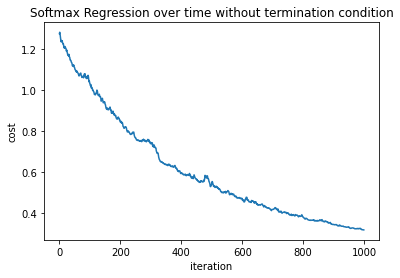

In [ ]:
acc_h, cost_h = classifier.getAccuracyAndCostHistory()
plt.plot(range(len(cost_h)), cost_h)
plt.ylabel('cost')
plt.xlabel('iteration')
plt.title('Softmax Regression over time without termination condition')
plt.show()

Accuracy over time

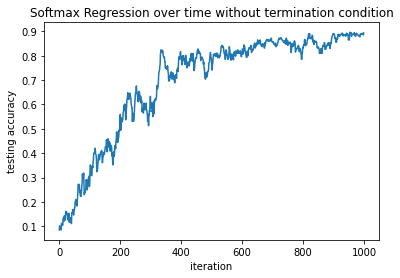

In [ ]:
plt.plot(range(len(acc_h)), acc_h)
plt.xlabel('iteration')
plt.title('Softmax Regression over time without termination condition')
plt.ylabel('testing accuracy')
plt.show()

##### __with__ termination condition

In [ ]:
def getClassifierWithGoodTerminationCondition():
    while True:
        optimizer = GradientDescent(learning_rate=0.1)
        termination_classifier = SoftmaxRegression(lmbda=0.00)
        # We learn the digits on the first half of the digits
        termination_classifier.fit(X_train, y_train, X_test, y_test, optimizer, termination_bound=10)
        num_iterations = termination_classifier.getTotalIterations()
        accuracy = termination_classifier.getAccuracy(X_test, y_test)
        cost_h = termination_classifier.cost
        if (num_iterations < 800 and num_iterations > 100 and accuracy > 0.80 and np.isnan(np.sum(cost_h)) == False):
            print(f'num_iterations: {num_iterations} ; accuracy: {accuracy}')
            return termination_classifier

Cost over time:

In [ ]:
termination_classifier = getClassifierWithGoodTerminationCondition()

num_iterations: 606 ; accuracy: 0.9018518518518519


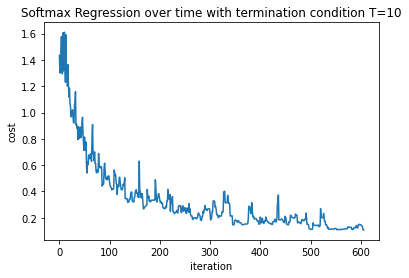

In [ ]:
acc_h, cost_h = termination_classifier.getAccuracyAndCostHistory()
plt.plot(range(len(cost_h)), cost_h)
plt.ylabel('cost')
plt.xlabel('iteration')
plt.title('Softmax Regression over time with termination condition T=10')
plt.show()

Accuracy over time

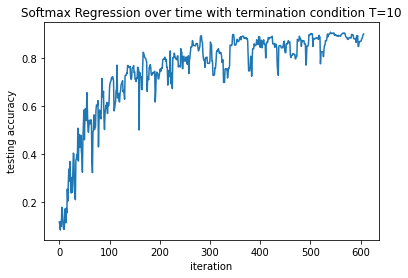

In [ ]:
plt.plot(range(len(acc_h)), acc_h)
plt.ylabel('testing accuracy')
plt.xlabel('iteration')
plt.title('Softmax Regression over time with termination condition T=10')
plt.show()

#### Softmax:

In [ ]:
try:
    digits_perf_df = pd.read_csv(f'{path}/digits_perf_df.csv')
except FileNotFoundError:
    digits_perf_df = run_analysis(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                                  validation_size=validation_size, betas=betas, learning_rates=learning_rates,
                                  batch_sizes=batch_sizes, verbose=False, k_fold=5)
digits_perf_df

,beta,learning_rate,batch_size,trainingAccuracy,testingAccuracy,performance
0,0.01,0.0001,1.0,0.918708,0.875417,4.467430
1,0.01,0.0001,2.0,0.939866,0.899889,2.895208
2,0.01,0.0001,5.0,0.965479,0.915462,1.947239
3,0.01,0.0001,10.0,0.983296,0.933259,1.651118
4,0.01,0.0001,25.0,0.993318,0.948832,1.483165
...,...,...,...,...,...,...
457,0.99,1.0000,50.0,1.000000,0.956618,1.467563
458,0.99,1.0000,229.0,1.000000,0.937709,1.871449
459,0.99,1.0000,408.0,1.000000,0.935484,1.719678
460,0.99,1.0000,587.0,1.000000,0.935484,2.086926


#### KNN

In [ ]:
digits_perf_KNN_df = run_analysis_KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
digits_perf_KNN_df

0.00% completed
6.67% completed
13.33% completed
20.00% completed
26.67% completed
33.33% completed
40.00% completed
46.67% completed
53.33% completed
60.00% completed
66.67% completed
73.33% completed
80.00% completed
86.67% completed
93.33% completed


,num_neighbours,power_parameter,trainingAccuracy,testingAccuracy,performance
0,1.0,1.0,1.000000,0.984064,0.004667
1,3.0,1.0,0.993638,0.981673,0.004094
2,5.0,1.0,0.989264,0.981673,0.004236
3,7.0,1.0,0.986282,0.979283,0.004179
4,9.0,1.0,0.983698,0.975299,0.004167
5,11.0,1.0,0.979523,0.972112,0.004134
6,13.0,1.0,0.978131,0.968924,0.004367
7,15.0,1.0,0.971769,0.964940,0.004238
8,17.0,1.0,0.968986,0.963347,0.004238
9,19.0,1.0,0.968191,0.959363,0.004350


#### Decision Tree

In [ ]:
digits_perf_tree_df = run_analysis_tree(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
digits_perf_tree_df

0.00% completed
0.89% completed
1.79% completed
2.68% completed
3.57% completed
4.46% completed
5.36% completed
6.25% completed
7.14% completed
8.04% completed
8.93% completed
9.82% completed
10.71% completed
11.61% completed
12.50% completed
13.39% completed
14.29% completed
15.18% completed
16.07% completed
16.96% completed
17.86% completed
18.75% completed
19.64% completed
20.54% completed
21.43% completed
22.32% completed
23.21% completed
24.11% completed
25.00% completed
25.89% completed
26.79% completed
27.68% completed
28.57% completed
29.46% completed
30.36% completed
31.25% completed
32.14% completed
33.04% completed
33.93% completed
34.82% completed
35.71% completed
36.61% completed
37.50% completed
38.39% completed
39.29% completed
40.18% completed
41.07% completed
41.96% completed
42.86% completed
43.75% completed
44.64% completed
45.54% completed
46.43% completed
47.32% completed
48.21% completed
49.11% completed
50.00% completed
50.89% completed
51.79% completed
52.68% co

,criterion,splitter,max_features,max_depth,trainingAccuracy,testingAccuracy,performance
0,gini,random,None,2,0.352883,0.328287,0.001553
1,gini,random,None,4,0.674155,0.654980,0.002037
2,gini,random,None,6,0.833002,0.749004,0.002871
3,gini,random,None,8,0.934592,0.841434,0.003928
4,gini,random,None,10,0.989463,0.822311,0.003909
...,...,...,...,...,...,...,...
219,entropy,best,log2,20,1.000000,0.785657,0.002798
220,entropy,best,log2,22,1.000000,0.795219,0.002798
221,entropy,best,log2,24,1.000000,0.768924,0.003130
222,entropy,best,log2,26,1.000000,0.780876,0.002836


#### Naive Bayes

In [ ]:
digits_perf_NB_df = run_analysis_NB(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
digits_perf_NB_df

,trainingAccuracy,testingAccuracy,performance
0,0.884095,0.850199,0.001562


### Testing the IRIS OPEN-ML dataset:

#### Loading and splitting the dataset:

In [ ]:
from sklearn.datasets import fetch_openml
dataset_iris = fetch_openml(data_id=42186)

dataset_iris['target'] = np.where(dataset_iris['target']=='Iris-setosa', 0, dataset_iris['target'])
dataset_iris['target'] = np.where(dataset_iris['target']=='Iris-versicolor', 1, dataset_iris['target'])
dataset_iris['target'] = np.where(dataset_iris['target']=='Iris-virginica', 2, dataset_iris['target'])

#note that the seeds targets are strings and 1,2,3. so we convert to int and substract 1 cz classes must start at 0
x_iris, y_iris = dataset_iris['data'], dataset_iris['target'].astype('int')

print(np.unique(y_iris))

[0 1 2]


In [ ]:
# Split data into train and test subsets

X_train, X_test, y_train, y_test, validation_size = data_split(data=x_iris, target=y_iris, test_size=0.7, shuffle=True)

batch_sizes = [1, 2, 5, 10, 25, 50]
for i in list(range(50, X_test.shape[0]-1, X_test.shape[0]//5)):
    if i not in batch_sizes:
        batch_sizes.append(i)
print(batch_sizes)

[1, 2, 5, 10, 25, 50]


#### Softmax:

In [ ]:
try:
    iris_perf_df = pd.read_csv(f'{path}/iris_perf_df.csv')
except FileNotFoundError:
    iris_perf_df = run_analysis(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                                  validation_size=validation_size, betas=betas, learning_rates=learning_rates,
                                  batch_sizes=batch_sizes, verbose=False, k_fold=5)
iris_perf_df

,beta,learning_rate,batch_size,trainingAccuracy,testingAccuracy,performance
0,0.01,0.0001,1.0,0.364286,0.371429,0.345666
1,0.01,0.0001,2.0,0.492857,0.361905,0.254783
2,0.01,0.0001,5.0,0.666667,0.666667,0.204674
3,0.01,0.0001,10.0,0.740476,0.685714,0.186978
4,0.01,0.0001,25.0,0.823810,0.752381,0.176795
...,...,...,...,...,...,...
247,0.99,1.0000,2.0,0.916667,0.866667,0.259059
248,0.99,1.0000,5.0,0.919048,0.933333,0.210001
249,0.99,1.0000,10.0,0.971429,0.971429,0.191581
250,0.99,1.0000,25.0,0.973810,0.933333,0.176858


#### KNN

In [ ]:
iris_perf_KNN_df = run_analysis_KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, 
                                    betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False, k_fold=5)
iris_perf_KNN_df

0.00% completed
6.67% completed
13.33% completed
20.00% completed
26.67% completed
33.33% completed
40.00% completed
46.67% completed
53.33% completed
60.00% completed
66.67% completed
73.33% completed
80.00% completed
86.67% completed
93.33% completed


,num_neighbours,power_parameter,trainingAccuracy,testingAccuracy,performance
0,1.0,1.0,1.000000,0.942857,0.000615
1,3.0,1.0,0.973810,0.961905,0.000312
2,5.0,1.0,0.969048,0.952381,0.000391
3,7.0,1.0,0.957143,0.952381,0.000348
4,9.0,1.0,0.969048,0.961905,0.000504
5,11.0,1.0,0.966667,0.971429,0.000306
6,13.0,1.0,0.969048,0.971429,0.000373
7,15.0,1.0,0.952381,0.961905,0.000314
8,17.0,1.0,0.950000,0.933333,0.000439
9,19.0,1.0,0.954762,0.952381,0.000390


#### Decision Tree:

In [ ]:
iris_perf_tree_df = run_analysis_tree(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
iris_perf_tree_df

0.00% completed
0.89% completed
1.79% completed
2.68% completed
3.57% completed
4.46% completed
5.36% completed
6.25% completed
7.14% completed
8.04% completed
8.93% completed
9.82% completed
10.71% completed
11.61% completed
12.50% completed
13.39% completed
14.29% completed
15.18% completed
16.07% completed
16.96% completed
17.86% completed
18.75% completed
19.64% completed
20.54% completed
21.43% completed
22.32% completed
23.21% completed
24.11% completed
25.00% completed
25.89% completed
26.79% completed
27.68% completed
28.57% completed
29.46% completed
30.36% completed
31.25% completed
32.14% completed
33.04% completed
33.93% completed
34.82% completed
35.71% completed
36.61% completed
37.50% completed
38.39% completed
39.29% completed
40.18% completed
41.07% completed
41.96% completed
42.86% completed
43.75% completed
44.64% completed
45.54% completed
46.43% completed
47.32% completed
48.21% completed
49.11% completed
50.00% completed
50.89% completed
51.79% completed
52.68% co

,criterion,splitter,max_features,max_depth,trainingAccuracy,testingAccuracy,performance
0,gini,random,None,2,0.835714,0.838095,0.000347
1,gini,random,None,4,0.950000,0.904762,0.000281
2,gini,random,None,6,0.990476,0.923810,0.000356
3,gini,random,None,8,0.992857,0.923810,0.000266
4,gini,random,None,10,1.000000,0.923810,0.000353
...,...,...,...,...,...,...,...
219,entropy,best,log2,20,1.000000,0.961905,0.000425
220,entropy,best,log2,22,1.000000,0.942857,0.000388
221,entropy,best,log2,24,1.000000,0.942857,0.000321
222,entropy,best,log2,26,1.000000,0.876190,0.000524


#### Naive Bayes:

In [ ]:
iris_perf_NB_df = run_analysis_NB(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
iris_perf_NB_df

,trainingAccuracy,testingAccuracy,performance
0,0.95,0.942857,0.000752


### Testing seismic-bumps OPEN-ML dataset

#### Loading and splitting the dataset:

In [ ]:
from sklearn.datasets import fetch_openml
dataset_seisms = fetch_openml(data_id=1500)

# #note that the seeds targets are strings and 1,2,3. so we convert to int and substract 1 cz classes must start at 0
x_seisms, y_seisms = dataset_seisms['data'], (np.array(list(map(int, dataset_seisms['target']))) - 1).astype('int')

print(len(y_seisms))
print(np.unique(y_seisms))

210
[0 1 2]


In [ ]:
# Split data into train and test subsets

X_train, X_test, y_train, y_test, validation_size = data_split(data=x_seisms, target=y_seisms, test_size=0.7, shuffle=True)

batch_sizes = [1, 2, 5, 10, 25, 50]
for i in list(range(50, X_test.shape[0]-1, X_test.shape[0]//5)):
    if i not in batch_sizes:
        batch_sizes.append(i)
print(batch_sizes)

[1, 2, 5, 10, 25, 50]


#### Softmax:

In [ ]:
try:
    seisms_perf_df = pd.read_csv(f'{path}/seisms_perf_df.csv')
except FileNotFoundError:
    seisms_perf_df = run_analysis(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                                  validation_size=validation_size, betas=betas, learning_rates=learning_rates,
                                  batch_sizes=batch_sizes, verbose=False, k_fold=5)
seisms_perf_df

,beta,learning_rate,batch_size,trainingAccuracy,testingAccuracy,performance
0,0.01,0.0001,1.0,0.365079,0.319728,0.324975
1,0.01,0.0001,2.0,0.460317,0.408163,0.265106
2,0.01,0.0001,5.0,0.682540,0.680272,0.210353
3,0.01,0.0001,10.0,0.730159,0.775510,0.198882
4,0.01,0.0001,25.0,0.888889,0.911565,0.185216
...,...,...,...,...,...,...
415,0.99,1.0000,50.0,0.920635,0.884354,0.171697
416,0.99,1.0000,50.0,0.920635,0.870748,0.177411
417,0.99,1.0000,79.0,0.920635,0.877551,0.171682
418,0.99,1.0000,108.0,0.920635,0.891156,0.172749


#### KNN:

In [ ]:
seisms_perf_KNN_df = run_analysis_KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
seisms_perf_KNN_df

0.00% completed
6.67% completed
13.33% completed
20.00% completed
26.67% completed
33.33% completed
40.00% completed
46.67% completed
53.33% completed
60.00% completed
66.67% completed
73.33% completed
80.00% completed
86.67% completed
93.33% completed


,num_neighbours,power_parameter,trainingAccuracy,testingAccuracy,performance
0,1.0,1.0,1.000000,0.889655,0.000534
1,3.0,1.0,0.947458,0.889655,0.000355
2,5.0,1.0,0.918644,0.903448,0.000402
3,7.0,1.0,0.922034,0.903448,0.000507
4,9.0,1.0,0.905085,0.903448,0.000485
5,11.0,1.0,0.913559,0.896552,0.000322
6,13.0,1.0,0.915254,0.903448,0.000416
7,15.0,1.0,0.913559,0.896552,0.000405
8,17.0,1.0,0.913559,0.896552,0.000407
9,19.0,1.0,0.908475,0.903448,0.000354


#### Decision Tree

In [ ]:
seisms_perf_tree_df = run_analysis_tree(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
seisms_perf_tree_df

0.00% completed
0.89% completed
1.79% completed
2.68% completed
3.57% completed
4.46% completed
5.36% completed
6.25% completed
7.14% completed
8.04% completed
8.93% completed
9.82% completed
10.71% completed
11.61% completed
12.50% completed
13.39% completed
14.29% completed
15.18% completed
16.07% completed
16.96% completed
17.86% completed
18.75% completed
19.64% completed
20.54% completed
21.43% completed
22.32% completed
23.21% completed
24.11% completed
25.00% completed
25.89% completed
26.79% completed
27.68% completed
28.57% completed
29.46% completed
30.36% completed
31.25% completed
32.14% completed
33.04% completed
33.93% completed
34.82% completed
35.71% completed
36.61% completed
37.50% completed
38.39% completed
39.29% completed
40.18% completed
41.07% completed
41.96% completed
42.86% completed
43.75% completed
44.64% completed
45.54% completed
46.43% completed
47.32% completed
48.21% completed
49.11% completed
50.00% completed
50.89% completed
51.79% completed
52.68% co

,criterion,splitter,max_features,max_depth,trainingAccuracy,testingAccuracy,performance
0,gini,random,None,2,0.827119,0.848276,0.000549
1,gini,random,None,4,0.910169,0.868966,0.000289
2,gini,random,None,6,0.984746,0.882759,0.000414
3,gini,random,None,8,0.996610,0.868966,0.000308
4,gini,random,None,10,1.000000,0.848276,0.000904
...,...,...,...,...,...,...,...
219,entropy,best,log2,20,1.000000,0.903448,0.000499
220,entropy,best,log2,22,1.000000,0.882759,0.000530
221,entropy,best,log2,24,1.000000,0.868966,0.000481
222,entropy,best,log2,26,1.000000,0.896552,0.000532


#### Naive Bayes

In [ ]:
seisms_perf_NB_df = run_analysis_NB(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
seisms_perf_NB_df

,trainingAccuracy,testingAccuracy,performance
0,0.911864,0.917241,0.000652


### Testing credit-G 2 classes OPEN-ML Dataset:


#### Loading and splitting the dataset:

In [ ]:
betas = [0.01,0.2,0.5,0.8, 0.9, 0.95, 0.99]
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]

from sklearn.datasets import fetch_openml
dataset_credit = fetch_openml(data_id=1500)

x_credit, y_credit = dataset_credit['data'], (np.array(list(map(int, dataset_credit['target']))) - 1).astype('int')

print(np.unique(y_credit))

[0 1 2]


In [ ]:
# Split data into train and test subsets
X_train, X_test, y_train, y_test, validation_size = data_split(data=x_credit, target=y_credit, test_size=0.7, shuffle=True)

batch_sizes = [1, 2, 5, 10, 25, 50]
for i in list(range(50, X_test.shape[0]-1, X_test.shape[0]//5)):
    if i not in batch_sizes:
        batch_sizes.append(i)
print(batch_sizes)

[1, 2, 5, 10, 25, 50]


#### Softmax:

In [ ]:
try:
    credit_perf_df = pd.read_csv(f'{path}/credit_perf_df.csv')
except FileNotFoundError:
    credit_perf_df = run_analysis(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                                  validation_size=validation_size, betas=betas, learning_rates=learning_rates,
                                  batch_sizes=batch_sizes, verbose=False, k_fold=5)
credit_perf_df

,beta,learning_rate,batch_size,trainingAccuracy,testingAccuracy,performance
0,0.01,0.0001,1.0,0.365079,0.408163,0.343601
1,0.01,0.0001,2.0,0.555556,0.551020,0.260316
2,0.01,0.0001,5.0,0.904762,0.857143,0.204104
3,0.01,0.0001,10.0,0.888889,0.877551,0.201605
4,0.01,0.0001,25.0,0.920635,0.884354,0.194676
...,...,...,...,...,...,...
415,0.99,1.0000,50.0,0.888889,0.870748,0.172930
416,0.99,1.0000,50.0,0.888889,0.870748,0.172563
417,0.99,1.0000,79.0,0.888889,0.870748,0.174380
418,0.99,1.0000,108.0,0.888889,0.870748,0.174607


#### Softmax:

#### KNN:

In [ ]:
credit_perf_KNN_df = run_analysis_KNN(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
credit_perf_KNN_df

0.00% completed
6.67% completed
13.33% completed
20.00% completed
26.67% completed
33.33% completed
40.00% completed
46.67% completed
53.33% completed
60.00% completed
66.67% completed
73.33% completed
80.00% completed
86.67% completed
93.33% completed


,num_neighbours,power_parameter,trainingAccuracy,testingAccuracy,performance
0,1.0,1.0,1.000000,0.917241,0.000449
1,3.0,1.0,0.959322,0.910345,0.000324
2,5.0,1.0,0.930508,0.889655,0.000388
3,7.0,1.0,0.925424,0.917241,0.000536
4,9.0,1.0,0.925424,0.910345,0.000420
5,11.0,1.0,0.922034,0.917241,0.000332
6,13.0,1.0,0.925424,0.917241,0.000428
7,15.0,1.0,0.925424,0.917241,0.000326
8,17.0,1.0,0.928814,0.910345,0.000397
9,19.0,1.0,0.925424,0.910345,0.000455


#### Decision Tree

In [ ]:
credit_perf_tree_df = run_analysis_tree(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
credit_perf_tree_df

0.00% completed
0.89% completed
1.79% completed
2.68% completed
3.57% completed
4.46% completed
5.36% completed
6.25% completed
7.14% completed
8.04% completed
8.93% completed
9.82% completed
10.71% completed
11.61% completed
12.50% completed
13.39% completed
14.29% completed
15.18% completed
16.07% completed
16.96% completed
17.86% completed
18.75% completed
19.64% completed
20.54% completed
21.43% completed
22.32% completed
23.21% completed
24.11% completed
25.00% completed
25.89% completed
26.79% completed
27.68% completed
28.57% completed
29.46% completed
30.36% completed
31.25% completed
32.14% completed
33.04% completed
33.93% completed
34.82% completed
35.71% completed
36.61% completed
37.50% completed
38.39% completed
39.29% completed
40.18% completed
41.07% completed
41.96% completed
42.86% completed
43.75% completed
44.64% completed
45.54% completed
46.43% completed
47.32% completed
48.21% completed
49.11% completed
50.00% completed
50.89% completed
51.79% completed
52.68% co

,criterion,splitter,max_features,max_depth,trainingAccuracy,testingAccuracy,performance
0,gini,random,None,2,0.864407,0.875862,0.000463
1,gini,random,None,4,0.942373,0.855172,0.000278
2,gini,random,None,6,0.988136,0.868966,0.000362
3,gini,random,None,8,1.000000,0.931034,0.000318
4,gini,random,None,10,1.000000,0.875862,0.000455
...,...,...,...,...,...,...,...
219,entropy,best,log2,20,1.000000,0.917241,0.000415
220,entropy,best,log2,22,1.000000,0.855172,0.000528
221,entropy,best,log2,24,1.000000,0.924138,0.000446
222,entropy,best,log2,26,1.000000,0.910345,0.000534


#### Naive Bayes

In [ ]:
credit_perf_NB_df = run_analysis_NB(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, betas=betas, learning_rates=learning_rates, batch_sizes=batch_sizes, verbose=False)
credit_perf_NB_df

,trainingAccuracy,testingAccuracy,performance
0,0.918644,0.896552,0.00103


## 3.2 Implement and use 5-fold cross validation to estimate performance, in terms of accuracy

In [ ]:
# In all of the experiments with respect to batch sizes, learning rates, and momentum parameters, and report the best hyper-parameters you found.
# 5 fold here..


# track and analyze the validation and training accuracy


## Visualization of hyper-parameters optimization

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def show_3d_plot(perf_df, vmin=None, vmax=None):
    betas, learning_rates, batch_sizes = list(zip(*perf_df.index))

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(projection='3d')
    c = perf_df['testingAccuracy']

    p = ax.scatter(xs=learning_rates, ys=betas, zs=batch_sizes, c=c, cmap='YlGnBu', vmin=vmin, vmax=vmax)

    ax.set_xlabel('learning rate')
    ax.set_ylabel('beta')
    ax.set_zlabel('batch size')
    cbar = fig.colorbar(p)
    cbar.set_label('mean validation accuracy', rotation=270)

In [ ]:
def get_algo_perf_comparison_df(perf_df):
    dict_list = []
    for i, df in enumerate(perf_df):
        performance_summary = {'mean':df['testingAccuracy'].quantile([0.90, 1]).mean(),
                               'std':df['testingAccuracy'].std(),
                               'min':df['testingAccuracy'].min(),
                               'max':df['testingAccuracy'].max()}
        dict_list.append(performance_summary)

    return pd.DataFrame(dict_list)

In [ ]:
def get_algo_time_comparison_df(perf_df):
    dict_list = []
    for i, df in enumerate(perf_df):
        running_time_summary = {'mean':df['performance'].mean(),
                               'std':df['performance'].std(),
                               }
        dict_list.append(running_time_summary)

    return pd.DataFrame(dict_list)

In [ ]:
def plot_perf_comparison_df(df):
    colors=["red", "green", "blue", "purple"]
    plt.axhline(y=100, zorder=0)

    shift = df['mean'].mean()*100

    plt.bar(range(len(['Softmax', 'KNN', 'Decision Tree', 'Naive Bayes'])), (df['max'])*100-shift, bottom=shift, 
            yerr=df['std'], align='center', alpha=0.5, color=colors)

    plt.xticks(range(len(df.columns)), ['Softmax', 'KNN', 'Decision Tree', 'Naive Bayes'])
    plt.ylabel('Testing Accuracy')
    plt.title('Testing Accuracy across different classifier')
    plt.show()

#### MNIST Digits:

In [ ]:
try:
    digits_perf_df.set_index(['beta', 'learning_rate', 'batch_size'], inplace=True)
except KeyError:
    # indices have already been updated!
    pass
digits_perf_df.to_csv('./data/digits_perf_df.csv')
digits_perf_df

trainingAccuracy  testingAccuracy  performance
beta learning_rate batch_size                                                
0.01 0.0001        1.0                 0.918708         0.875417     4.467430
                   2.0                 0.939866         0.899889     2.895208
                   5.0                 0.965479         0.915462     1.947239
                   10.0                0.983296         0.933259     1.651118
                   25.0                0.993318         0.948832     1.483165
...                                         ...              ...          ...
0.99 1.0000        50.0                1.000000         0.956618     1.467563
                   229.0               1.000000         0.937709     1.871449
                   408.0               1.000000         0.935484     1.719678
                   587.0               1.000000         0.935484     2.086926
                   766.0               1.000000         0.933259     2.092856

[462 rows x 3 columns]

In [ ]:
digits_comparison_list = [digits_perf_df, digits_perf_KNN_df, digits_perf_tree_df, digits_perf_NB_df]

digits_perf_comp_df = get_algo_perf_comparison_df(digits_comparison_list)
digits_perf_comp_df['std'] = digits_perf_comp_df['std'].fillna(0)
digits_perf_comp_df

,mean,std,min,max
0,0.956007,0.086472,0.110122,0.958843
1,0.986853,0.010754,0.950598,0.989641
2,0.848367,0.139217,0.262948,0.859761
3,0.850199,0.000000,0.850199,0.850199


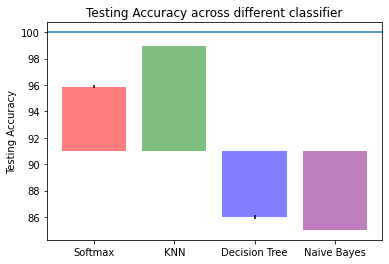

In [ ]:
plot_perf_comparison_df(digits_perf_comp_df)

In [ ]:
digits_comparison_list = [digits_perf_df, digits_perf_KNN_df, digits_perf_tree_df, digits_perf_NB_df]

digits_time_comp_df = get_algo_time_comparison_df(digits_comparison_list)
digits_time_comp_df['std'] = digits_time_comp_df['std'].fillna(0)
digits_time_comp_df.rename(columns={0:'Softmax'})

,mean,std
0,2.096849,0.858572
1,0.004268,0.000174
2,0.003507,0.004075
3,0.001562,0.000000


In [ ]:
best_parameters_index = digits_perf_df['testingAccuracy'].argmax()
digits_perf_df.iloc[best_parameters_index]

trainingAccuracy    1.000000
testingAccuracy     0.958843
performance         1.433596
Name: (0.5, 0.001, 50.0), dtype: float64

In [ ]:
worst_parameters_index = digits_perf_df['testingAccuracy'].argmin()
digits_perf_df.iloc[worst_parameters_index]

trainingAccuracy    0.110245
testingAccuracy     0.110122
performance         4.437975
Name: (0.99, 0.0001, 1.0), dtype: float64

To avoid outliers, we compute \[0.20, 1.00\] accuracy interval


In [ ]:
lower_bound, upper_bound = seisms_perf_df['testingAccuracy'].quantile([0.20, 1.0])
print(lower_bound, upper_bound)

0.6721088435374151 0.9387755102040816


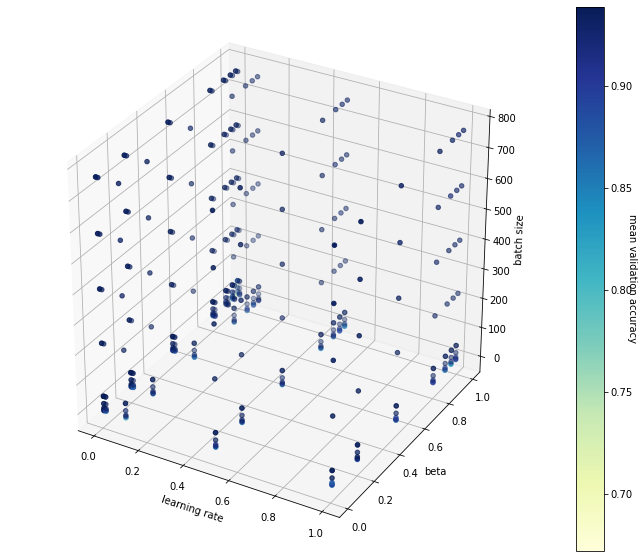

In [ ]:
show_3d_plot(digits_perf_df, vmin=lower_bound, vmax=upper_bound)

#### Iris:

In [ ]:
try:
    iris_perf_df.set_index(['beta', 'learning_rate', 'batch_size'], inplace=True)
except KeyError:
    # indices have already been updated!
    pass
iris_perf_df.to_csv('./data/iris_perf_df.csv')
iris_perf_df

trainingAccuracy  testingAccuracy  performance
beta learning_rate batch_size                                                
0.01 0.0001        1.0                 0.364286         0.371429     0.345666
                   2.0                 0.492857         0.361905     0.254783
                   5.0                 0.666667         0.666667     0.204674
                   10.0                0.740476         0.685714     0.186978
                   25.0                0.823810         0.752381     0.176795
...                                         ...              ...          ...
0.99 1.0000        2.0                 0.916667         0.866667     0.259059
                   5.0                 0.919048         0.933333     0.210001
                   10.0                0.971429         0.971429     0.191581
                   25.0                0.973810         0.933333     0.176858
                   50.0                0.983333         0.971429     0.170761

[252 rows x 3 columns]

In [ ]:
iris_comparison_list = [iris_perf_df, iris_perf_KNN_df, iris_perf_tree_df, iris_perf_NB_df]

iris_perf_comp_df = get_algo_perf_comparison_df(iris_comparison_list)
iris_perf_comp_df['std'] = iris_perf_comp_df['std'].fillna(0)
iris_perf_comp_df

,mean,std,min,max
0,0.985714,0.213983,0.247619,0.990476
1,0.971429,0.013329,0.923810,0.971429
2,0.966667,0.043241,0.619048,0.980952
3,0.942857,0.000000,0.942857,0.942857


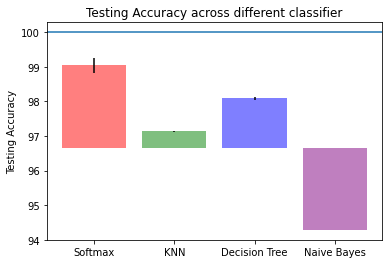

In [ ]:
plot_perf_comparison_df(iris_perf_comp_df)

In [ ]:
best_parameters_index = iris_perf_df['testingAccuracy'].argmax()
iris_perf_df.iloc[best_parameters_index]

trainingAccuracy    0.978571
testingAccuracy     0.990476
performance         0.174195
Name: (0.8, 0.1, 25.0), dtype: float64

In [ ]:
worst_parameters_index = iris_perf_df['testingAccuracy'].argmin()
iris_perf_df.iloc[worst_parameters_index]

trainingAccuracy    0.309524
testingAccuracy     0.247619
performance         0.200729
Name: (0.99, 0.0001, 5.0), dtype: float64

To avoid outliers, we compute \[0.20, 1.00\] accuracy interval


In [ ]:
lower_bound, upper_bound = seisms_perf_df['testingAccuracy'].quantile([0.20, 1.0])
print(lower_bound, upper_bound)

0.6721088435374151 0.9387755102040816


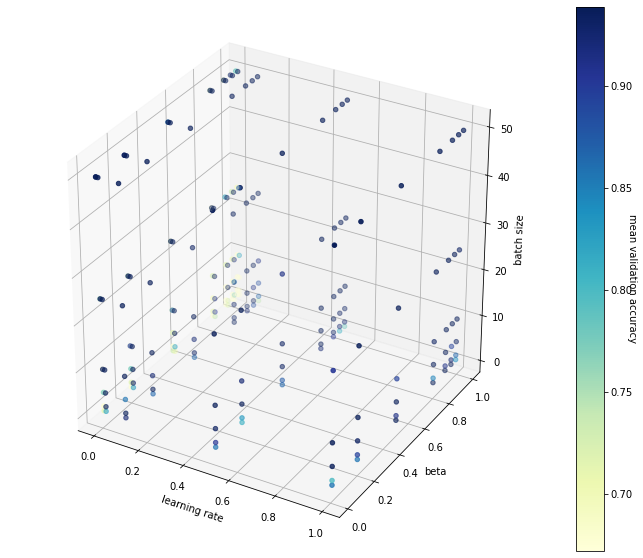

In [ ]:
show_3d_plot(iris_perf_df, vmin=lower_bound, vmax=upper_bound)

#### Seismic-bumps

In [ ]:
try:
    seisms_perf_df.set_index(['beta', 'learning_rate', 'batch_size'], inplace=True)
except KeyError:
    # indices have already been updated!
    pass
seisms_perf_df.to_csv('./data/seisms_perf_df.csv')
seisms_perf_df

trainingAccuracy  testingAccuracy  performance
beta learning_rate batch_size                                                
0.01 0.0001        1.0                 0.365079         0.319728     0.324975
                   2.0                 0.460317         0.408163     0.265106
                   5.0                 0.682540         0.680272     0.210353
                   10.0                0.730159         0.775510     0.198882
                   25.0                0.888889         0.911565     0.185216
...                                         ...              ...          ...
0.99 1.0000        50.0                0.920635         0.884354     0.171697
                   50.0                0.920635         0.870748     0.177411
                   79.0                0.920635         0.877551     0.171682
                   108.0               0.920635         0.891156     0.172749
                   137.0               0.904762         0.884354     0.173302

[420 rows x 3 columns]

In [ ]:
seisms_comparison_list = [seisms_perf_df, seisms_perf_KNN_df, seisms_perf_tree_df, seisms_perf_NB_df]

seisms_perf_comp_df = get_algo_perf_comparison_df(seisms_comparison_list)
seisms_perf_comp_df['std'] = seisms_perf_comp_df['std'].fillna(0)
seisms_perf_comp_df

,mean,std,min,max
0,0.928571,0.172294,0.319728,0.938776
1,0.913793,0.008626,0.875862,0.917241
2,0.910345,0.040150,0.586207,0.924138
3,0.917241,0.000000,0.917241,0.917241


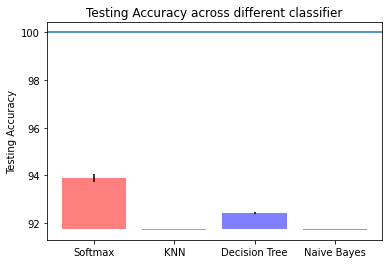

In [ ]:
plot_perf_comparison_df(seisms_perf_comp_df)

In [ ]:
best_parameters_index = seisms_perf_df['testingAccuracy'].argmax()
seisms_perf_df.iloc[best_parameters_index]

trainingAccuracy    0.920635
testingAccuracy     0.938776
performance         0.174740
Name: (0.2, 1.0, 50.0), dtype: float64

In [ ]:
worst_parameters_index = seisms_perf_df['testingAccuracy'].argmin()
seisms_perf_df.iloc[worst_parameters_index]

trainingAccuracy    0.365079
testingAccuracy     0.319728
performance         0.324975
Name: (0.01, 0.0001, 1.0), dtype: float64

To avoid outliers, we compute \[0.20, 1.00\] accuracy interval


In [ ]:
lower_bound, upper_bound = seisms_perf_df['testingAccuracy'].quantile([0.20, 1.0])
print(lower_bound, upper_bound)

0.6721088435374151 0.9387755102040816


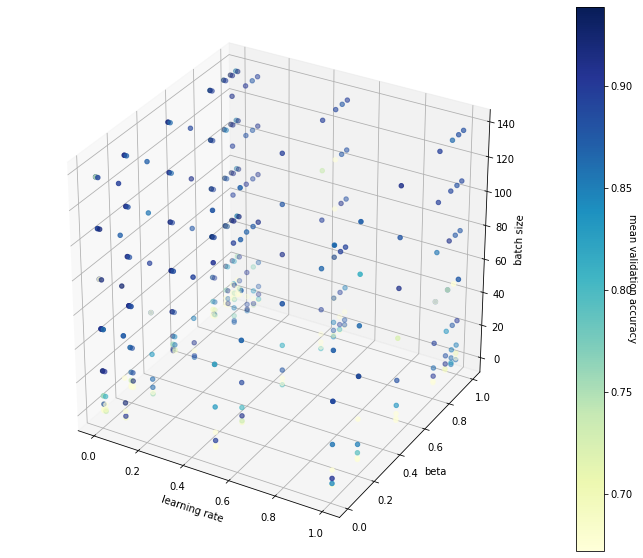

In [ ]:
show_3d_plot(seisms_perf_df, vmin=lower_bound, vmax=upper_bound)

#### Credit-G

In [ ]:
try:
    credit_perf_df.set_index(['beta', 'learning_rate', 'batch_size'], inplace=True)
except KeyError:
    # indices have already been updated!
    pass
credit_perf_df.to_csv('./data/credit_perf_df.csv')

credit_perf_df

trainingAccuracy  testingAccuracy  performance
beta learning_rate batch_size                                                
0.01 0.0001        1.0                 0.365079         0.408163     0.343601
                   2.0                 0.555556         0.551020     0.260316
                   5.0                 0.904762         0.857143     0.204104
                   10.0                0.888889         0.877551     0.201605
                   25.0                0.920635         0.884354     0.194676
...                                         ...              ...          ...
0.99 1.0000        50.0                0.888889         0.870748     0.172930
                   50.0                0.888889         0.870748     0.172563
                   79.0                0.888889         0.870748     0.174380
                   108.0               0.888889         0.870748     0.174607
                   137.0               0.888889         0.870748     0.196500

[420 rows x 3 columns]

In [ ]:
credit_comparison_list = [credit_perf_df, credit_perf_KNN_df, credit_perf_tree_df, credit_perf_NB_df]

credit_perf_comp_df = get_algo_perf_comparison_df(credit_comparison_list)
credit_perf_comp_df['std'] = credit_perf_comp_df['std'].fillna(0)
credit_perf_comp_df

,mean,std,min,max
0,0.904762,0.146672,0.319728,0.911565
1,0.920690,0.009708,0.889655,0.924138
2,0.920690,0.037965,0.600000,0.931034
3,0.896552,0.000000,0.896552,0.896552


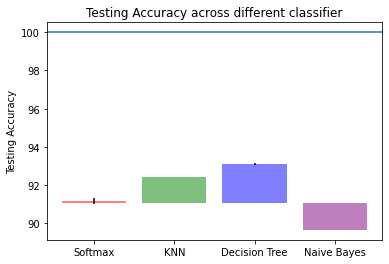

In [ ]:
plot_perf_comparison_df(credit_perf_comp_df)

In [ ]:
best_parameters_index = credit_perf_df['testingAccuracy'].argmax()
credit_perf_df.iloc[best_parameters_index]

trainingAccuracy    0.936508
testingAccuracy     0.911565
performance         0.187248
Name: (0.2, 0.001, 25.0), dtype: float64

In [ ]:
worst_parameters_index = credit_perf_df['testingAccuracy'].argmin()
credit_perf_df.iloc[worst_parameters_index]

trainingAccuracy    0.365079
testingAccuracy     0.319728
performance         0.316129
Name: (0.99, 0.0001, 1.0), dtype: float64

To avoid outliers, we compute \[0.20, 1.00\] accuracy interval


In [ ]:
lower_bound, upper_bound = seisms_perf_df['testingAccuracy'].quantile([0.20, 1.0])
print(lower_bound, upper_bound)

0.6721088435374151 0.9387755102040816


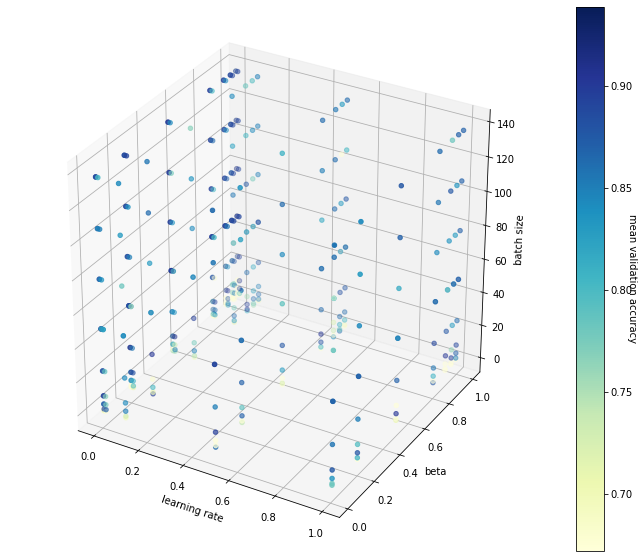

In [ ]:
show_3d_plot(credit_perf_df, vmin=lower_bound, vmax=upper_bound)